In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.sparse.linalg
import cv2
import itertools
import random
import os
import numba
import sys
sys.path.append("../../")
import helpers
import gfx

# Disable Numba deprecation warnings (need to find long-term fix)
import warnings
warnings.simplefilter("ignore", category=numba.NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=numba.NumbaPendingDeprecationWarning)
warnings.simplefilter("ignore", category=numba.NumbaPerformanceWarning)

# Heterogeneous Material Matching
Uptill now we have considered material matching of objects consisting of just a single material / color. In the real world, objects hardly ever consist of just a single material. In this notebook we will look at objects consisting of multiple materials such as the sphere below.

Wall time: 3.56 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
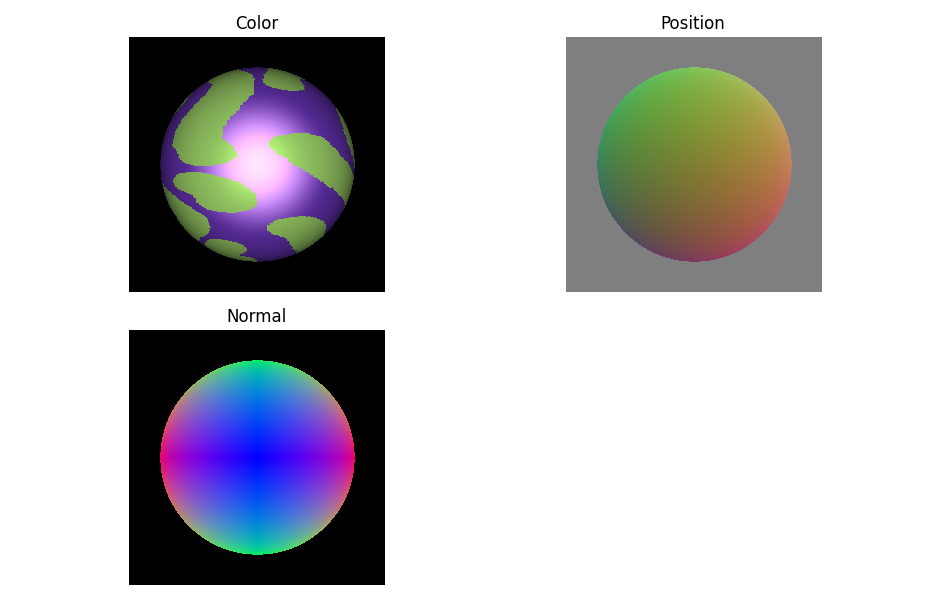

In [2]:
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
light = gfx.DirectionalLight(gfx.Vec3(0, 0, 1), gfx.Vec3(1, 1, 1))
brdf0 = gfx.PhongBRDF(gfx.Vec3(0.6, 0.8, 0.4), gfx.Vec3(0.2, 0.3, 0.15), 6)
brdf1 = gfx.PhongBRDF(gfx.Vec3(0.4, 0.2, 0.7), gfx.Vec3(0.8, 0.7, 0.6), 2)
brdfs = numba.typed.List()
brdfs.extend([brdf0, brdf1])

material_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week5", "material_mask0.jpg"))
material_mask = (material_mask > 0.5).astype(np.int32)

%time colors, positions, normals = gfx.render_heterogeneous(camera, sphere, light, brdfs, material_mask, 256, 256)
helpers.show_images({
    "Color": np.clip(colors, 0.0, 1.0),
    "Position": (positions+2.5)/5,
    "Normal": np.abs(normals)
}, nrows=2, ncols=2)

##  Estimating the material map
To model an object consisting of multiple materials we will estimate a material map. The material map assigns a material index to each screen pixel. This material map can later be used to estimate the different BRDFs separately (see notebook 5.1).

As the color image above illustrates, the most dominant part of the Phong model is the diffuse term. The estimate of the $k_d$ parameter is thus a good differentiating factor between the different materials that the objects is made out of.

Thus, we need to make an estimate of $k_d$ without knowing $k_s$ or $t$. Recall the Phong equation and how it is made up out of the diffuse component (left side) and the specular component (right side):

$$
k_d I (L \cdot N) + k_s I (E \cdot R)^t
$$

The specular component mostly relies on the $E \cdot R$. If it is very low then the whole specular component will contribute very little to the pixel color. We can use this knowledge to estimate $k_d$ by looking only at those pixels where $E \cdot R$ is low and estimating $k_d$ as if the specular component is zero, such that $C = k_d I (L \cdot N)$.


### Exercise 6 (3 points)
Implement the function `estimate_kd_per_pixel` which estimates the $k_d$ parameter using the method above. You are given a list of images taken with different light positions such that there is always at least one image in which the specular component of a pixel is low.

C:\Users\GONEM_~1\AppData\Local\Temp/ipykernel_13340/1979623314.py:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  kd_estimate[row, col] = np.linalg.lstsq(A, b)[0]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
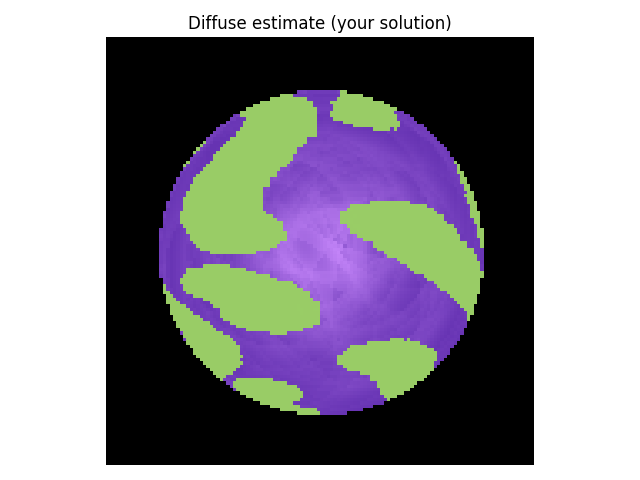

In [11]:
random.seed(53223)
np.random.seed(54323)

# Inputs of this function are:
# - camera     use camera.position to get the position of the camera
# - positions  an image which stores a 3D position at each pixel
# - normals    an image that stores the 3D normal vectors at each pixel
# - light_with_color_images    a list with tuples (light, image)
def estimate_kd_per_pixel(camera, positions, normals, light_with_color_images):

    # we have to play with the threshold
    threshold = 0.5
    assert threshold > 0
    kd_estimate = np.zeros(positions.shape)
    
    for row in range(kd_estimate.shape[0]):
        for col in range(kd_estimate.shape[1]):
            normal = normals[row][col]

            # not part of image -> skip
            if not normal.any():
                continue
            normal = normal / np.linalg.norm(normal)
            position = positions[row][col]

            A = np.zeros((0, 3))
            b = np.zeros(0)

            for light, image in light_with_color_images:
                light_direction, light_color = light.light_at_point(position)

                R = gfx.reflect(normal, light_direction)
                R = R / np.linalg.norm(R)
                E = camera.position - position
                E = E / np.linalg.norm(E)
                dotER = max(np.dot(E, R), 0)

                # inside specular -> skip
                if dotER >= threshold:
                    continue

                dotnL = max(np.dot(normal, light_direction), 0)
                diff = light_color * dotnL

                A_rows = diff * np.identity(3)
                A = np.vstack((A, A_rows))
                b = np.concatenate((b, image[row][col]))
            
            kd_estimate[row, col] = np.linalg.lstsq(A, b)[0]

    return kd_estimate

camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)

brdf0 = gfx.PhongBRDF(gfx.Vec3(0.6, 0.8, 0.4), gfx.Vec3(0.2, 0.3, 0.15), 6)
brdf1 = gfx.PhongBRDF(gfx.Vec3(0.4, 0.2, 0.7), gfx.Vec3(0.8, 0.7, 0.6), 2)
brdfs = numba.typed.List()
brdfs.extend([brdf0, brdf1])

material_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week5", "material_mask0.jpg"))
material_mask = (material_mask > 0.5).astype(np.int32)

def take_virtual_pictures():
    width = height = 128
    light_with_color_images = []
    for i in range(40):
        light = gfx.DirectionalLight(gfx.sample_uniform_hemisphere(), gfx.Vec3(1,1,1))
        color_image, positions, normals = gfx.render_heterogeneous(camera, sphere, light, brdfs, material_mask, width, height)
        # positions/normals are the same for any image. Variables live outside the loop in Python
        light_with_color_images.append((light, color_image))
    return camera, positions, normals, light_with_color_images

# Take a couple of pictures with our virtual camera
camera, positions, normals, light_with_color_images = take_virtual_pictures()

kd_estimate = estimate_kd_per_pixel(camera, positions, normals, light_with_color_images)

helpers.show_image(kd_estimate, "Diffuse estimate (your solution)")

### Tests of exercise 6
Your code should estimate the $k_d$ value for every pixel. In practice this means that the resulting image should should assign purple/green values to each pixel. Due to the limited number of input pictures, there will be some dark regions and other artefacts. This exercise will be tested with a large margin of error (Sum of Squared Differences of $0.025$ average per pixel).

In [ ]:
random.seed(53223)
np.random.seed(54323)

camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
#light = gfx.DirectionalLight(gfx.Vec3(0,0,1), gfx.Vec3(1, 1, 1))

brdf0 = gfx.PhongBRDF(gfx.Vec3(0.6, 0.8, 0.4), gfx.Vec3(0.2, 0.3, 0.15), 6)
brdf1 = gfx.PhongBRDF(gfx.Vec3(0.4, 0.2, 0.7), gfx.Vec3(0.8, 0.7, 0.6), 2)
brdfs = numba.typed.List()
brdfs.extend([brdf0, brdf1])

material_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week5", "material_mask0.jpg"))
material_mask = (material_mask > 0.5).astype(np.int32)

width = height = 128

def take_virtual_pictures():
    light_with_color_images = []
    for i in range(40):
        light = gfx.DirectionalLight(gfx.sample_uniform_hemisphere(), gfx.Vec3(1,1,1))
        color_image, positions, normals = gfx.render_heterogeneous(camera, sphere, light, brdfs, material_mask, width, height)
        # positions/normals are the same for any image. Variables live outside the loop in Python
        light_with_color_images.append((light, color_image))
    return camera, positions, normals, light_with_color_images

# Take a couple of pictures with our virtual camera
camera, positions, normals, light_with_color_images = take_virtual_pictures()
kd = gfx.render_heterogeneous_kd(camera, sphere, brdfs, material_mask, width, height)
kd_estimate = estimate_kd_per_pixel(camera, positions, normals, light_with_color_images)
print(f"Error: {helpers.SSD_per_pixel(kd, kd_estimate)}")

## Grouping similar pixels
We now have a map containing the (estimated) diffuse parameter $k_d$ for each pixel. Our goal is to assign to each pixel a number to indicate to which of the two materials (purple/green) it belongs. An effective and (relatively) simple algorithm to do so is k-means. K-means is a clustering algorithm: given a collection of points, it tries to create $n$ clusters.

It works as follows:
* Initialize the cluster centers to random input points
* Loop
 * Assign samples to the nearest cluster center
 * Compute new cluster centers as the mean of the samples belonging to each cluster

The random initalization may sometimes lead to the algorithm getting stuck in a suboptimal solution. Therefor is is common to repeat the process multiple times and to take the best result. We provide a `kmeans(samples, num_clusters)` implementation so you don't need to use `cv2.kmeans`.

In [ ]:
def kmeans(samples, num_clusters, max_iterations = 20, num_attempts = 50):
    best_SSD = None
    best_clusters = None
    best_centers = None
    
    for _ in range(num_attempts):
        # Initialize centers to random samples
        indices = np.random.permutation(np.arange(len(samples)))[:num_clusters]
        centers = samples[indices]
        
        for _ in range(max_iterations):
            dists = np.zeros((len(samples), num_clusters))
            for i, center in enumerate(centers):
                dists[:, i] = np.linalg.norm(samples - centers[i], axis=1)

            clusters = np.argmin(dists, axis=1)
            for i in range(num_clusters):
                centers[i] = np.mean(np.compress(clusters == i, samples, axis=0), axis=0)
               
            my_SSD = 0
            for i in range(num_clusters):
                vecs_to_cluster_center = np.compress(clusters == i, samples, axis=0) - centers[i]
                dists_to_cluster_center = np.linalg.norm(vecs_to_cluster_center, axis=1)
                my_SSD += np.sum(dists_to_cluster_center**2)

            if not best_SSD or my_SSD < best_SSD:
                best_SSD = my_SSD
                best_clusters = clusters
                best_centers = centers
    
    return best_clusters, best_centers

np.random.seed(890329)
samples1 = np.random.normal((2,3), 0.4, (100,2))
samples2 = np.random.normal((-1,2), 0.3, (100,2))
samples3 = np.random.normal((0,-1), 0.4, (100,2))
samples = np.vstack([samples1, samples2, samples3])
np.random.shuffle(samples)

labels, centers = kmeans(samples, 3, 20, 10)

labels_reference = np.load(os.path.join(helpers.dataset_folder, "week5", "kmeans_example_labels.npy"))
centers_reference = np.load(os.path.join(helpers.dataset_folder, "week5", "kmeans_example_centers.npy"))

def plot_axis(ax, labels, centers):
    ax.set_title("K-means clustering")
    ax.axis("equal")
    for i in range(3):
        ax.scatter(samples[labels==i,0], samples[labels==i,1], label=f"Cluster {i} samples")
    ax.scatter(centers[:,0], centers[:,1], label="K-means centers")
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 6))
plot_axis(ax1, labels, centers)
plot_axis(ax2, labels, centers)
#fig.show()

### Exercise 7 (2 points)
Implement a function that uses the code from the previous exercise to compute a material map. The material map is an image that assigns a number to each pixel on the screen to specify to which material it belongs to. Make sure the material index always stays in the range of 0 up to (but not including) `num_materials`. Background pixels (where $\lVert N \rVert =0$) should be assigned a number equal to or higher than `num_materials` to indicate no valid material could be found.

In [ ]:
def group_pixels_by_material(diffuse_image, num_materials):
    # YOUR CODE HERE
    raise NotImplementedError()
    
camera = gfx.Camera(gfx.Vec3(0, 0, -5), gfx.Vec3(0, 0, 0), gfx.Vec3(0, 1, 0), 45.0, 1.0)
sphere = gfx.Sphere(gfx.Vec3(0, 0, 0), 1.5)
#light = DirectionalLight(gfx.Vec3(0,0,1), gfx.Vec3(1, 1, 1))

brdf0 = gfx.PhongBRDF(gfx.Vec3(0.6, 0.8, 0.4), gfx.Vec3(0.2, 0.3, 0.15), 6)
brdf1 = gfx.PhongBRDF(gfx.Vec3(0.4, 0.2, 0.7), gfx.Vec3(0.8, 0.7, 0.6), 2)
brdfs = numba.typed.List()
brdfs.extend([brdf0, brdf1])

material_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week5", "material_mask0.jpg"))
material_mask = (material_mask > 0.5).astype(np.int32)

# Ensure we get the same results from k-means each time we execute this code cell.
random.seed(53223)
np.random.seed(54323)

width = height = 128
diffuse_image = gfx.render_heterogeneous_kd(camera, sphere, brdfs, material_mask, width, height)
%time material_ids = group_pixels_by_material(diffuse_image, 2)

helpers.show_images({ "Material index estimate (your solution)": material_ids / 2 }, nrows=1, ncols=2)

### Tests of exercise 7
Test your solution by checking whether pixels are correctly grouped.